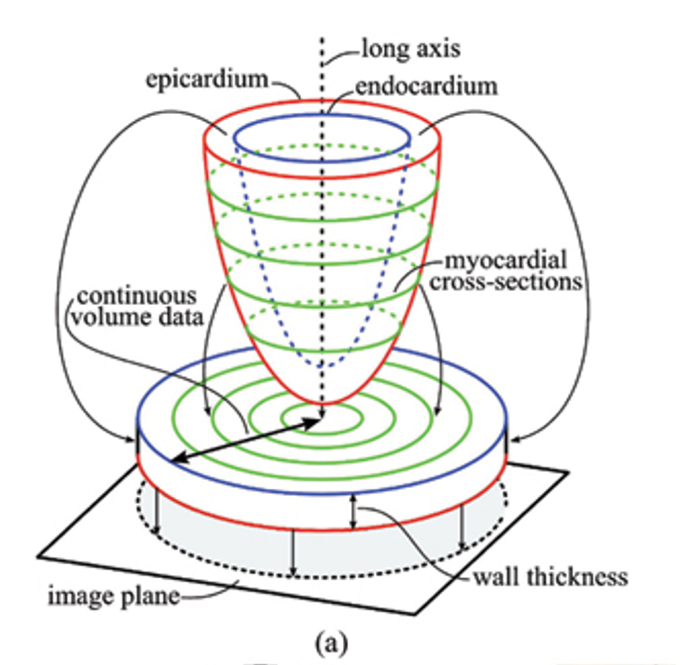

In [1]:
'''
Author: LiuSheng
Date: 2025-02-26 14:17:40
LastEditTime: 2025-02-26 14:49:29
Description: 
'''
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, shift
import SimpleITK as sitk


fingerprint_filepath = r"D:\workspace\SPECT_project\fingerprint.json"

with open(fingerprint_filepath, "r") as f:
    fingerprint = json.load(f)
    
    
imgpath = r"Y:\labspace\DataCollection\Project\RadiSmart\cardiac\healthy_nii\000149118\108_SA.nii.gz"
imgpath = r"Y:\labspace\DataCollection\Project\RadiSmart\cardiac\healthy_nii\000149118\108_From_SA_scaled.nii.gz"
sitk_img = sitk.ReadImage(imgpath)
scaled_sa_img = sitk.GetArrayFromImage(sitk_img)[0]
scaled_sa_img = np.transpose(scaled_sa_img, (1, 0, 2))

imgpath = r"Y:\labspace\DataCollection\Project\RadiSmart\cardiac\healthy_nii\000149118\seg.nii.gz"
sitk_img = sitk.ReadImage(imgpath)
mask_img = sitk.GetArrayFromImage(sitk_img)
mask_img = np.transpose(mask_img, (1, 0, 2))


print(scaled_sa_img.shape, mask_img.shape)


(57, 60, 60) (57, 60, 60)


{'center': {'cy': 33, 'cx': 29}, 'radius': 11, 'apex_z': np.int64(12), 'base_z': np.int64(48), 'dividing_z': np.int64(26), 'thickness': 6}


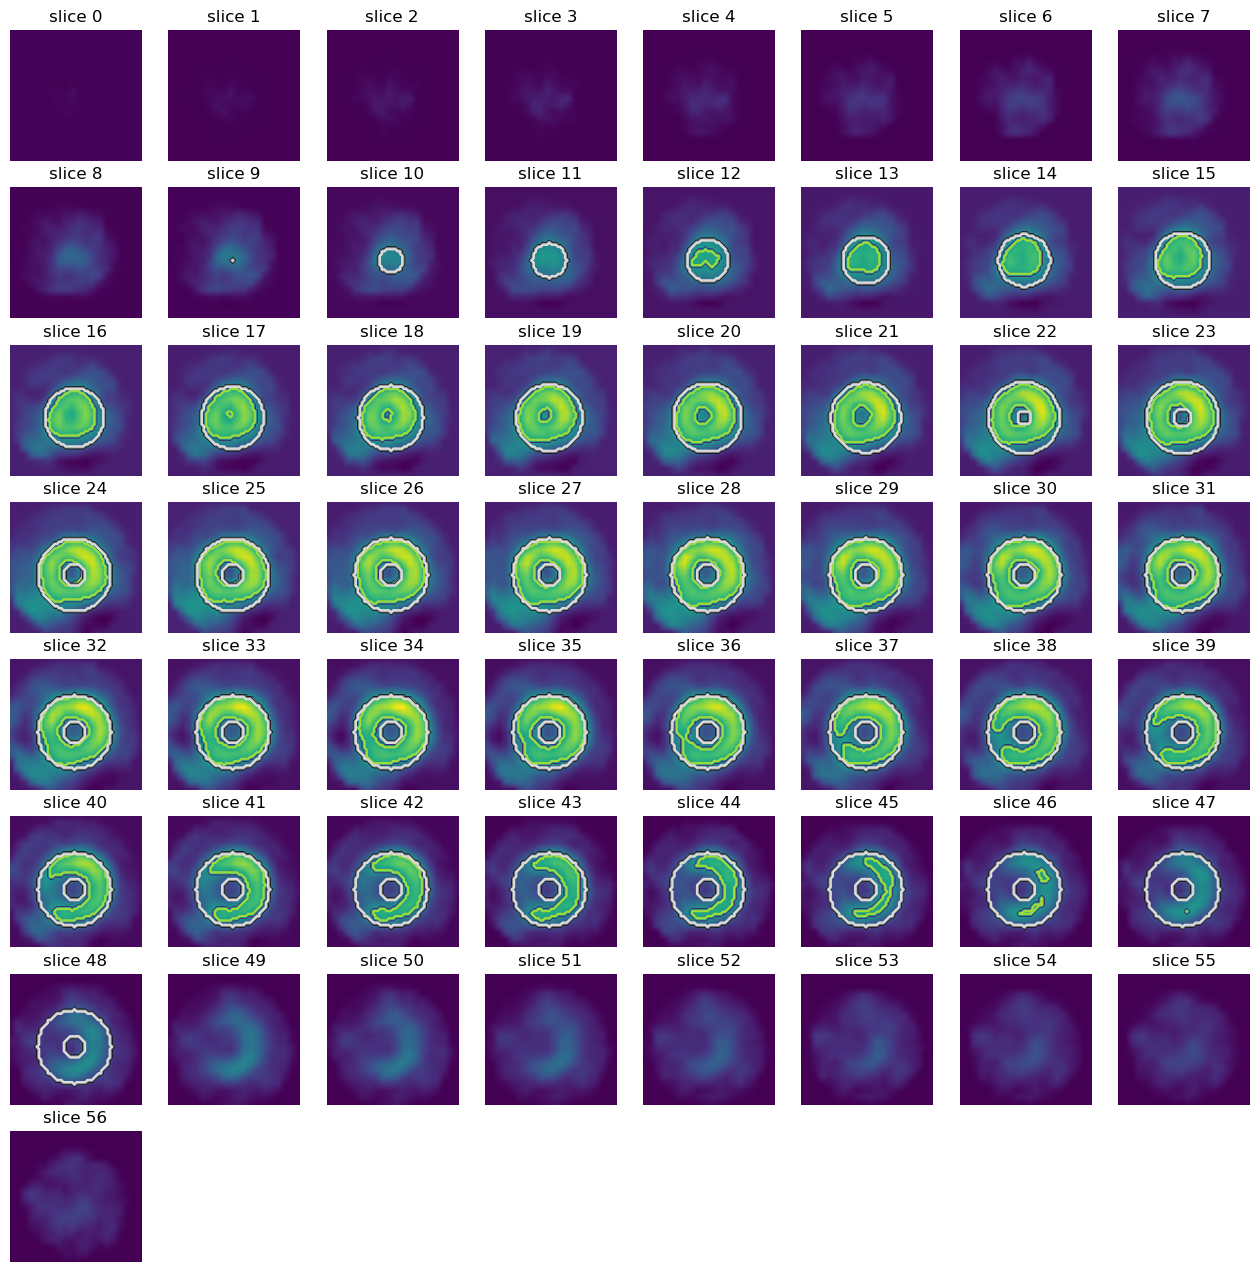

In [66]:
# step 3: generate mask3d
def generate_lv_model_mask3d(img3d, param, thickness=3):
    # 根据传入的参数, 生成心脏mask
    # cylinder: circle_param 中只含有 center + radius
    # hybrid: 比 cylinder 多 apex_z, base_z
    # hybrid with plane: 比 hybrid 多 plane

    z_len, y_len, x_len = img3d.shape  # 使用 img3d 的形状
    # 使用 np.ogrid 生成三维坐标网格
    Z, Y, X = np.ogrid[:z_len, :y_len, :x_len]
    
    center = param["center"]
    radius = param["radius"]
    cy, cx = center["cy"], center["cx"]
    
    # 计算每个点与圆心在 XY 平面上的距离 (忽略 z 轴)
    distance_xy = np.sqrt((Y - cy) ** 2 + (X - cx) ** 2 + Z*0)
    cylinder_mask3d = (distance_xy <= radius+thickness).astype(np.uint8)
    
    if param.get("apex_z", -1)==-1 and param.get("base_z", -1)==-1:
        return cylinder_mask3d
    
    # hybrid
    base_z = param["base_z"]
    dividing_z = param["dividing_z"]
    
    cylinder_mask3d = ((distance_xy <= radius+thickness) & (distance_xy >= radius-thickness) & (Z<=base_z) & (Z>=dividing_z)).astype(np.uint8)
    
    # distance_semicircle = np.sqrt((Y - cy) ** 2 + (X - cx) ** 2 + ((Z-dividing_z)/2) ** 2)
    distance_semicircle = np.sqrt((Y - cy) ** 2 + (X - cx) ** 2 + (Z-dividing_z) ** 2)
    semicircle_mask3d = ((distance_semicircle <= radius+thickness) & (distance_semicircle >= radius-thickness) & (Z<=dividing_z)).astype(np.uint8)
    
    hybrid_mask3d = cylinder_mask3d | semicircle_mask3d
    return hybrid_mask3d


zs, _, _ = np.where(mask_img)
apex_z = np.min(zs)
base_z = np.max(zs)
z_dim, y_dim, x_dim = mask_img.shape
radius = 11
param = {
    "center": {
        "cy": 33,
        "cx": 29
    },
    "radius": radius,
    "apex_z": apex_z,
    "base_z": base_z+1,
    "dividing_z": apex_z+radius+3,
    "thickness": 6
}
print(param)

model_mask3d = generate_lv_model_mask3d(mask_img, param, param["thickness"])


plt.figure(figsize=(16, 16))
for i in range(min(64, mask_img.shape[0])):
    ax = plt.subplot(8,8,i+1)
    plt.imshow(scaled_sa_img[i], vmax=np.max(scaled_sa_img))
    plt.contour(mask_img[i])
    plt.contour(model_mask3d[i], cmap="gray")
    # plt.show()
    ax.set_axis_off()
    ax.set_title(f"slice {i}")
    # break

In [74]:
np.stack([zs, ys, xs], axis=-1).shape

(128, 128, 3)

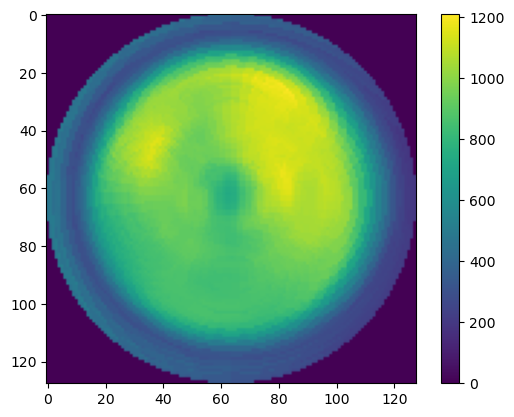

In [164]:
from scipy.interpolate import RegularGridInterpolator


def gen_bulleye(img3d, param, output_size=(128,128)):
    z_dim, y_dim, x_dim = img3d.shape
    # interpolator = RegularGridInterpolator((np.arange(z_dim), np.arange(y_dim)+0.5, np.arange(x_dim)+0.5), img3d*mask_img, bounds_error=False, fill_value=0)
    interpolator = RegularGridInterpolator((np.arange(z_dim), np.arange(y_dim)+0.5, np.arange(x_dim)+0.5), img3d, bounds_error=False, fill_value=0)
    # interpolator = RegularGridInterpolator((np.arange(z_dim), np.arange(y_dim), np.arange(x_dim)), img3d, bounds_error=False, fill_value=0)
    
    thickness = param["thickness"]
    polar_map3d = np.zeros((thickness+1, *output_size))
    
    radius = param["radius"]
    dividing_z = param["dividing_z"]
    semi_center = (dividing_z, param["center"]["cy"], param["center"]["cx"])
    
    Y,X = np.ogrid[:128, :128]
    Y = Y+0.5
    X = X+0.5
    
    distance2center = np.sqrt((Y - output_size[0]/2) ** 2 + (X - output_size[1]/2) ** 2)
    base_z = param["base_z"]

    for zi, offset in enumerate(np.arange(thickness+1)-thickness/2):
        r = radius+offset
        
        R_semi = np.pi/2 * r
        R_semi_in_polar = R_semi/(R_semi+base_z-dividing_z) * 64

        mask_semi = (distance2center <= R_semi_in_polar).astype(np.uint8)
        
        theta = distance2center / R_semi_in_polar * np.pi/2
        phi = np.arctan2(Y-output_size[0]/2, X-output_size[1]/2)
        

        zs = -r*np.cos(theta)
        ys = r*np.sin(theta)*np.sin(phi)
        xs = r*np.sin(theta)*np.cos(phi)

        zs = zs + dividing_z
        ys = ys + semi_center[1]
        xs = xs + semi_center[2]
        
        semi_img = interpolator(np.stack([zs, ys, xs], axis=-1))
        semi_img = interpolator(np.round(np.stack([zs, ys, xs], axis=-1)))
        
        polar_map3d[zi] = semi_img*mask_semi
        
        
        
        mask_cylinder = (distance2center > R_semi_in_polar) & (distance2center<output_size[0]/2)
        mask_cylinder = mask_cylinder.astype(np.uint8)
        
        
        zs = (distance2center-R_semi_in_polar)/(64-R_semi_in_polar)*(base_z-dividing_z)
        ys = r*np.sin(theta)*np.sin(phi)
        xs = r*np.sin(theta)*np.cos(phi)
        
        zs = zs + dividing_z
        ys = ys + semi_center[1]
        xs = xs + semi_center[2]
        
        cylinder_img = interpolator(np.stack([zs, ys, xs], axis=-1))
        
        cylinder_img = interpolator(np.round(np.stack([zs, ys, xs], axis=-1)))
        polar_map3d[zi]+= cylinder_img*mask_cylinder
        
    # polar_map3d = polar_map3d[:, ::-1, ::-1]
    plt.imshow(np.max(polar_map3d, axis=0))
    
    # plt.imshow(mask_cylinder)
    # plt.imshow(phi)
    plt.colorbar()
    
    return np.max(polar_map3d, axis=0)



param = {
    "center": {
        "cy": 33,
        "cx": 28.5
    },
    "radius": radius,
    "apex_z": apex_z,
    "base_z": base_z+1,
    "dividing_z": apex_z+radius+3,
    "thickness": 4
}

res = gen_bulleye(scaled_sa_img, param)
    

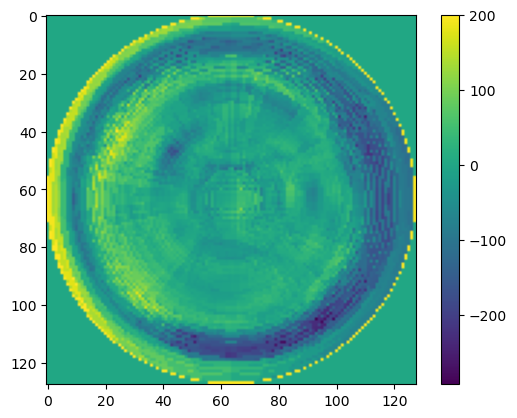

In [165]:
plt.imshow(res - polar_img, vmax=200)
plt.colorbar()

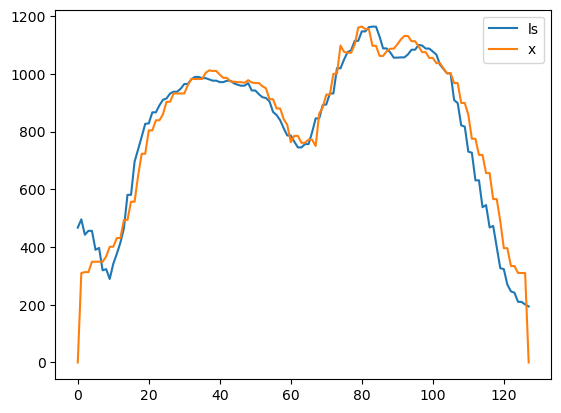

In [166]:
plt.plot(res[60], label='ls')
plt.plot(polar_img[60], label='x')
plt.legend()